In [1]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import pyh5md
from transforms3d import quaternions
import scipy.integrate
import itertools
import tidynamics
from glob import glob
from matplotlib.figure import SubplotParams
import os.path

π = np.pi

plt.rcParams['figure.figsize'] = (8*.7, 6*.7)
plt.rcParams['figure.subplot.hspace'] = .25
plt.rcParams['figure.subplot.wspace'] = .3
plt.rcParams['figure.subplot.left'] = .24
plt.rcParams['figure.subplot.bottom'] = .15
plt.rcParams['figure.subplot.top'] = 0.95
plt.rcParams['figure.subplot.right'] = 0.95

plt.rcParams['font.size'] = 12


In [11]:
# bead indices defining directions "1" and "2"

idx_1, idx_2 = 5, 33

runs = glob('/home/share/nanomotors/20180927/l69xy_h_p0_20926*/l69xy_*.h5')
runs.sort()

print(len(runs), "runs found")

20 runs found


## Read and analyze simulation data

For every simulation:
1. Compute the "body frame" velocity vB of the L particle
2. Integrate vB to obtain the "body frame" trajectory
3. Compute the cross-displacements and fit the slope to obtain the diffusion matrix

Run the cell below onces with `custom_TP = False`, obtain d1 and d2, then re-run
with `custom_TP = True`.

In [17]:


custom_TP = True
if custom_TP:
    delta_pos = np.array([d1, d2, 0])
else:
    delta_pos = np.zeros(3)

all_cdisp = []
v_mean = []
all_skip = 2

u_check = []

for r in runs[:]:
    try:
        tmp_try = pyh5md.File(r, 'r')
    except:
        continue
    with pyh5md.File(r, 'r') as a:
        if a['parameters/probability'][()] != 0.: continue
        #if a['parameters/do_hydro'][()] != 1: continue
        print(r)
        g = a.particles_group('janus')
        pos_0 = pyh5md.element(g, 'position').value[0]
        obs = a['observables']
        janus_pos = pyh5md.element(obs, 'janus_pos')
        janus_pos_dt = janus_pos.time*all_skip
        janus_pos = janus_pos.value[::all_skip]
        janus_vel = pyh5md.element(obs, 'janus_vel')
        janus_vel_dt = janus_vel.time*all_skip
        janus_vel = janus_vel.value[::all_skip]
        omega_body = pyh5md.element(obs, 'omega_body')
        omega_body_dt = omega_body.time*all_skip
        omega_body = omega_body.value[::all_skip]
        q = pyh5md.element(obs, 'q')
        q_qt = q.time*all_skip
        q = q.value[::all_skip]
        u = pyh5md.element(obs, 'u')
        u_dt = u.time*all_skip
        u = u.value[::all_skip]

    tmp_s = q[:,3].copy()
    tmp_v = q[:,:3].copy()
    q[:,1:4] = tmp_v
    q[:,0] = tmp_s
    del tmp_s, tmp_v

    omega = np.array([quaternions.rotate_vector(omega_body_i, q_i) for omega_body_i, q_i in zip(omega_body, q)])

    d_20_0 = np.sqrt(np.sum((pos_0[idx_2]-pos_0[0])**2))
    d_4_0 = np.sqrt(np.sum((pos_0[idx_1]-pos_0[0])**2))
    u_perp = (pos_0[idx_2,:]-pos_0[0,:])/d_20_0
    u_para = (pos_0[idx_1,:]-pos_0[0,:])/d_4_0

    u_perp = np.array([quaternions.rotate_vector(u_perp, q_i) for q_i in q])
    u_para = np.array([quaternions.rotate_vector(u_para, q_i) for q_i in q])

    u_check.append(np.einsum('...i,...i', u_perp, u_para))

    v1 = np.array([np.dot(v, u1) for v, u1 in zip(janus_vel, u_para)])
    v2 = np.array([np.dot(v, u2) for v, u2 in zip(janus_vel, u_perp)])

    if custom_TP:
        v_rel = np.cross(omega_body, delta_pos[None,:])

        v1 += v_rel[:,0]
        v2 += v_rel[:,1]
    
    disp1 = scipy.integrate.cumtrapz(v1)*janus_vel_dt
    disp2 = scipy.integrate.cumtrapz(v2)*janus_vel_dt
    dispt = scipy.integrate.cumtrapz(omega[:,2])*omega_body_dt

    disp_stride = 32
    disp1 = disp1[::disp_stride]
    disp2 = disp2[::disp_stride]
    dispt = dispt[::disp_stride]

    xyz = np.array(list(zip(disp1, disp2, dispt)))
    cdisp = tidynamics.cross_displacement(xyz)

    all_cdisp.append(cdisp)

    v_mean.append((v1.mean(), v2.mean(), omega[:,2].mean()))

v_mean = np.array(v_mean)

if custom_TP:
    cdisp_cus = all_cdisp.copy()
else:
    cdisp_com = all_cdisp.copy()

/home/share/nanomotors/20180927/l69xy_h_p0_20926299/l69xy_h_p0.h5
/home/share/nanomotors/20180927/l69xy_h_p0_20926300/l69xy_h_p0.h5
/home/share/nanomotors/20180927/l69xy_h_p0_20926301/l69xy_h_p0.h5
/home/share/nanomotors/20180927/l69xy_h_p0_20926302/l69xy_h_p0.h5
/home/share/nanomotors/20180927/l69xy_h_p0_20926303/l69xy_h_p0.h5
/home/share/nanomotors/20180927/l69xy_h_p0_20926304/l69xy_h_p0.h5
/home/share/nanomotors/20180927/l69xy_h_p0_20926305/l69xy_h_p0.h5
/home/share/nanomotors/20180927/l69xy_h_p0_20926306/l69xy_h_p0.h5
/home/share/nanomotors/20180927/l69xy_h_p0_20926307/l69xy_h_p0.h5
/home/share/nanomotors/20180927/l69xy_h_p0_20926308/l69xy_h_p0.h5
/home/share/nanomotors/20180927/l69xy_h_p0_20926309/l69xy_h_p0.h5
/home/share/nanomotors/20180927/l69xy_h_p0_20926310/l69xy_h_p0.h5
/home/share/nanomotors/20180927/l69xy_h_p0_20926311/l69xy_h_p0.h5
/home/share/nanomotors/20180927/l69xy_h_p0_20926312/l69xy_h_p0.h5
/home/share/nanomotors/20180927/l69xy_h_p0_20926313/l69xy_h_p0.h5
/home/shar

<IPython.core.display.Javascript object>


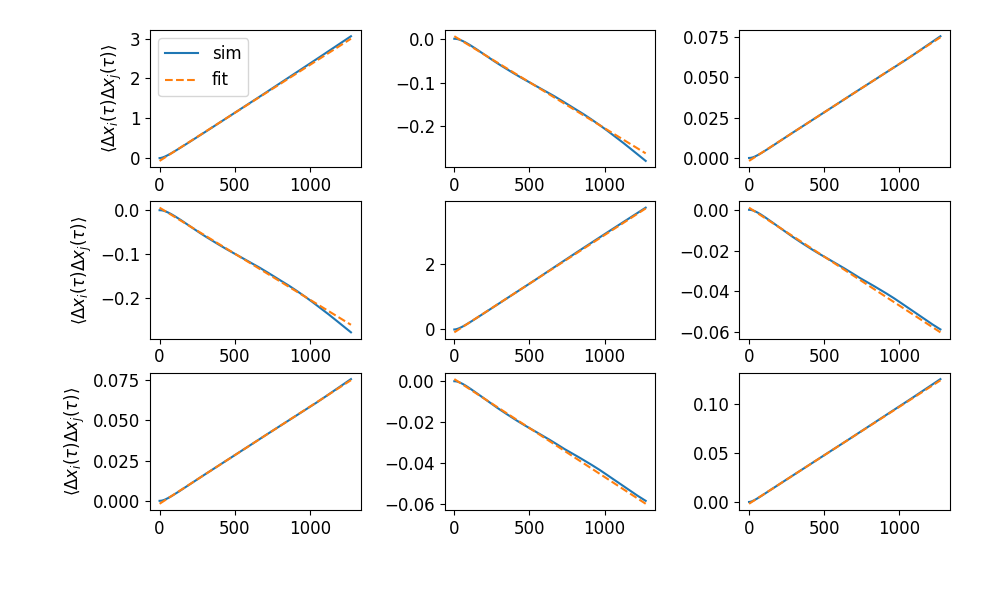

In [13]:
START, STOP = 5, 100

N_disp = 200

disp_time = np.arange(N_disp)*janus_vel_dt*disp_stride

cd = np.mean(cdisp_com, axis=0)
Ddata = np.zeros((3,3))

params = SubplotParams(wspace=0.40, left=.15)
plt.figure(figsize=(10, 6), subplotpars=params)

for i, j in itertools.product(range(3), range(3)):
    plt.subplot(3, 3, 3*i+j+1)

    m = cd[i][j]
    plt.plot(disp_time, m[:N_disp], label='sim')
    fit = np.polyfit(disp_time[START:STOP], m[START:STOP], 1)
    plt.plot(disp_time, np.poly1d(fit)(disp_time), label='fit', ls='--')

    if i==j==0:
        plt.legend()
    Ddata[i, j] = fit[-2]/2

    if j==0:
        plt.ylabel(r'$\langle \Delta x_i(\tau) \Delta x_j(\tau) \rangle$')


In [16]:
d1, d2 = -Ddata[1,2]/Ddata[2,2], Ddata[0,2]/Ddata[2,2]

print("Correction from CoM to CoH - from Chakrabarty et al 2014, Eq. 33")
print(d1, d2)

Correction from CoM to CoH - from Chakrabarty et al 2014, Eq. 33
0.4867513588193372 0.609921064280698


<IPython.core.display.Javascript object>


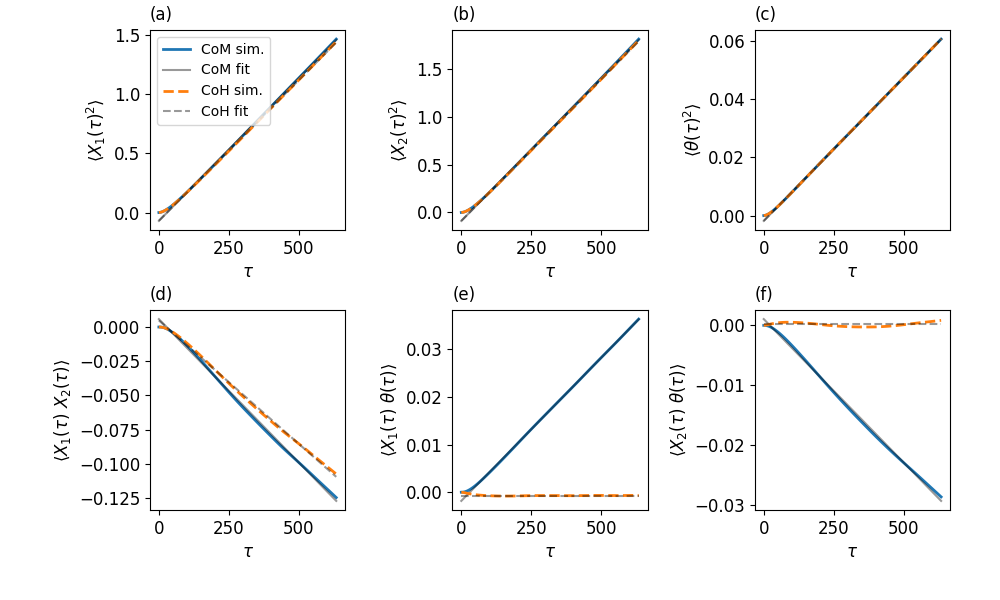

In [18]:
START, STOP = 5, 100

N_disp = 100

disp_time = np.arange(N_disp)*janus_vel_dt*disp_stride

cd_com = np.mean(cdisp_com, axis=0)
cd_cus = np.mean(cdisp_cus, axis=0)
D_com = np.zeros((3,3))
D_cus = np.zeros((3,3))

idx_list = [(0,0), (1, 1), (2, 2), (0, 1), (0, 2), (1, 2)]
label_list = [r'$\langle X_1(\tau)^2 \rangle$',
              r'$\langle X_2(\tau)^2 \rangle$',
              r'$\langle \theta(\tau)^2 \rangle$',
              r'$\langle X_1(\tau)\ X_2(\tau) \rangle$',
              r'$\langle X_1(\tau)\ \theta(\tau) \rangle$',
              r'$\langle X_2(\tau)\ \theta(\tau) \rangle$',
             ]
letter_list = 'abcdef'

params = SubplotParams(wspace=0.55, left=.15, hspace=0.4)
plt.figure(figsize=(10, 6), subplotpars=params)

subplot_idx = 0
for i, j in idx_list:
    subplot_idx += 1
    ax = plt.subplot(2, 3, subplot_idx)

    m = cd_com[i][j]
    plt.plot(disp_time, m[:N_disp], label='CoM sim.', ls='-', lw=2)
    fit = np.polyfit(disp_time[START:STOP], m[START:STOP], 1)
    plt.plot(disp_time, np.poly1d(fit)(disp_time), label='CoM fit', ls='-', alpha=0.4, color='k')
    D_com[i, j] = fit[-2]/2

    m = cd_cus[i][j]
    plt.plot(disp_time, m[:N_disp], label='CoH sim.', ls='--', lw=2)
    fit = np.polyfit(disp_time[START:STOP], m[START:STOP], 1)
    plt.plot(disp_time, np.poly1d(fit)(disp_time), label='CoH fit', ls='--', alpha=0.4, color='k')
    D_cus[i, j] = fit[-2]/2

    if subplot_idx==1:
        plt.legend(fontsize=10)
    plt.text(0., 1.05, '('+letter_list[subplot_idx-1]+')', transform=ax.transAxes)

    plt.xlabel(r'$\tau$')
    plt.ylabel(label_list[subplot_idx-1])

plt.savefig('L_eq_cdisp.pdf')

In [20]:
# print D_com with LaTeX table formatting
for line in D_com:
    l1, l2, l3 = map(lambda x: 10000*x, line)
    
    print('%3.2f & %3.2f & %3.2f \\cr' % (l1, l2, l3))


12.04 & -1.05 & 0.30 \cr
0.00 & 14.93 & -0.24 \cr
0.00 & 0.00 & 0.49 \cr


In [21]:
# print D_cus with LaTeX table formatting
for line in D_cus:
    l1, l2, l3 = map(lambda x: 10000*x, line)
    
    print('%3.2f & %3.2f & %3.2f \\cr' % (l1, l2, l3))


11.86 & -0.90 & -0.00 \cr
0.00 & 14.81 & 0.00 \cr
0.00 & 0.00 & 0.49 \cr


In [22]:
# Compute radius from force and torque

l = .638
X_dot = D_cus @ np.array([0, 1, l])
print(l, np.sqrt(X_dot[0]**2+X_dot[1]**2)/X_dot[2])


0.638 47.14892036237414
